In [1]:
% Ensemble Kalman Filter implementation
% v2. make different time step (dt ~= 1)available
clear;
close all;

## load data: forward problem

In [2]:
inputname1 = './data_transient/transient_1d_conduction_pulse1.mat';
load(inputname1,'time_grid','T_transient','R_transient','q_transient');

% original solutions
time_grid_solution = time_grid;
T_transient_solution = T_transient;
R_transient_solution = R_transient;
q_transient_solution = q_transient;

## hyperparameter settings filtering method

In [3]:
rng('default');
M_sample = 50; % INPUT
sigma_noise = 0.1; % [K] INPUT noise magnitude
q_noise = 10^8; % [W/m^3] INPUT 10^5
Rgap_noise = 0.1; % [ratio] INPUT error physics modeling on Rgap

## geometry

In [4]:
ro_heater = 4.25*10^-3; % [m]
ro_zro2 = 30.70*10^-3; % [m] instead of 30.734 mm
dr = 0.05*10^-3; % [m] grid size: can be greater than greatest common divisor of two lengths

r_grid_heater = linspace(0, ro_heater, 1+ro_heater/dr)'; % including interface
r_grid_zro2 = linspace(ro_heater, ro_zro2, 1+(ro_zro2-ro_heater)/dr)'; % including interface
r_grid_total = linspace(0, ro_zro2, 1+ro_zro2/dr)';
N_grid_heater = length(r_grid_heater);
N_grid_total = length(r_grid_total);

## temperature sensor placement (index)

In [5]:
% sensor_user_input = [100];
sensor_user_input = [146];

Nsensor = length(sensor_user_input);
Hobs = zeros(Nsensor, N_grid_total + 1); % observation matrix for augmented state [T, q]
for i = 1:Nsensor % Fill in the observation matrix
    Hobs(i, sensor_user_input(i)) = 1;
end
Gamma = diag(sigma_noise * ones(1, Nsensor)); % noise covariance matrix

## Inverse time steps

In [6]:
time_end = 100; % [s] INPUT last time
dt = 1; % [s] INPUT inverse time step size
time_grid = linspace(0, time_end, 1+time_end/dt)';
N_time = length(time_grid);

## translate original data onto inverse time step

In [7]:
T_transient_solution = myLinearInterp(time_grid_solution, T_transient', time_grid)';
R_transient_solution = myLinearInterp(time_grid_solution, R_transient, time_grid);
q_transient_solution = myLinearInterp(time_grid_solution, q_transient, time_grid);
noise = sigma_noise * randn([size(T_transient_solution) M_sample]); % Generating Gaussian noise
T_transient_solution_noisy =  repmat(T_transient_solution, [1, 1, M_sample]) + noise; % Adding the noise to the data matrix

## matrix (for individual sample): state, thermal properties, data

In [8]:
T_transient_sample = zeros(N_grid_total, N_time, M_sample);
q_transient_sample = zeros(N_time, M_sample);
R_transient_sample = zeros(N_time, M_sample); % [m^2-K/W]
Yobs_sample = zeros(Nsensor, N_time, M_sample);
Yobs_sample = repmat(Hobs(:,1:end-1)*T_transient_solution_noisy(:,1:N_time), [1, 1, M_sample]) + sigma_noise*randn(Nsensor, N_time, M_sample); % corrupted measurement

k_i = zeros(N_grid_total, M_sample); % thermal conductivity at node i
rhocp_i = zeros(N_grid_total, M_sample); % rho*c_p at node i
k_i_face = zeros(N_grid_total-1, M_sample); % correspond to i+1/2 location

## mean and std (estimation = after Kamlan correction)

In [9]:
T_transient_est_mean = zeros(N_grid_total, N_time);
q_transient_est_mean = zeros(N_time, 1);
R_transient_est_mean = zeros(N_time, 1);
T_transient_est_std = zeros(N_grid_total, N_time);
q_transient_est_std = zeros(N_time, 1);
R_transient_est_std = zeros(N_time, 1);

## statistics

In [10]:
Cov_MC_temp = zeros(N_grid_total+1, N_grid_total+1); % estimated covariance (updated each time step)
Var_MC = zeros(N_grid_total+1, N_time); % store variance of each state
K_MC = zeros(N_grid_total+1, Nsensor, N_time); % Kalman gain
state_augmented_sample_temp = zeros(N_grid_total+1, M_sample);

## physical properties

In [11]:
T_outer = 500 + 273.15; % [K] boundary condition

## initialization (t=0)

In [12]:
it = 1;
fprintf('initialization (time: %d second) \n', time_grid(it));

initialization (time: 0 second)

In [13]:

T_transient_sample(:,it,:) = T_outer;
state_augmented_sample_temp(1:end-1, :) = T_transient_sample(:,it,:);
state_augmented_sample_temp(end, :) = q_transient_sample(it,:);
Cov_MC_temp = cov(state_augmented_sample_temp');

idx = 1:N_grid_heater-1; % heater
k_i(idx,:) = k_T_heater(T_outer); % use kelvin for input temperature
rhocp_i(idx,:) = rhocp_T_heater(T_outer);

idx = N_grid_heater; % gap
R_transient_sample(it,:) = Rgap_T(T_outer)*(1 + Rgap_noise*randn(1,M_sample));
k_i(idx,:) = 1./(0.5/k_T_heater(T_outer) + 0.5/k_T_zro2(T_outer) + R_transient_sample(it,:)/dr);
rhocp_i(idx,:) = 0.5*(rhocp_T_heater(T_outer) + rhocp_T_zro2(T_outer));

idx = N_grid_heater+1:N_grid_total; % zro2
k_i(idx,:) = k_T_zro2(T_outer);
rhocp_i(idx,:) = rhocp_T_zro2(T_outer);

k_i_face = 1./(0.5./k_i(1:end-1,:) + 0.5./k_i(2:end, :));
% face #1: (1,2), face #2: (2,3), face #(N_grid_total-1):(N_grid_total-1, N_grid_total)

Var_MC(:, it) = sqrt(diag(Cov_MC_temp));

T_transient_est_mean(:,it) =  mean(T_transient_sample(:,it,:), 3);
q_transient_est_mean(it) = mean(q_transient_sample(it,:));
R_transient_est_mean(it) = mean(R_transient_sample(it,:));
T_transient_est_std(:,it) =  std(T_transient_sample(:,it,:), 0, 3);
q_transient_est_std(it) = std(q_transient_sample(it,:), 0);
R_transient_est_std(it) = std(R_transient_sample(it,:), 0);

## solve inverse problem (t>0)

In [14]:
for it=2:N_time
    fprintf('time: %d second \n', time_grid(it));

time: 1 second 
time: 2 second 
time: 3 second 
time: 4 second 
time: 5 second 
time: 6 second 
time: 7 second 
time: 8 second 
time: 9 second 
time: 10 second 
time: 11 second 
time: 12 second 
time: 13 second 
time: 14 second 
time: 15 second 
time: 16 second 
time: 17 second 
time: 18 second 
time: 19 second 
time: 20 second 
time: 21 second 
time: 22 second 
time: 23 second 
time: 24 second 
time: 25 second 
time: 26 second 
time: 27 second 
time: 28 second 
time: 29 second 
time: 30 second 
time: 31 second 
time: 32 second 
time: 33 second 
time: 34 second 
time: 35 second 
time: 36 second 
time: 37 second 
time: 38 second 
time: 39 second 
time: 40 second 
time: 41 second 
time: 42 second 
time: 43 second 
time: 44 second 
time: 45 second 
time: 46 second 
time: 47 second 
time: 48 second 
time: 49 second 
time: 50 second 
time: 51 second 
time: 52 second 
time: 53 second 
time: 54 second 
time: 55 second 
time: 56 second 
time: 57 second 
time: 58 second 
time: 59 second 
time: 

## evolution heat source (process noise)

In [15]:
    q_transient_sample(it,:) = q_transient_sample(it-1, :) + q_noise*randn(1,M_sample);

for m=1:M_sample % for each sample

## assign matrix values

In [16]:
    A = sparse(N_grid_total, N_grid_total); % new time step
    B = sparse(N_grid_total, N_grid_total); % prev time step
    C = sparse(N_grid_total, 1); % source term

## discretization for T equation

In [17]:
    % center symmetry line
    idx = 1;
    A(idx, idx) = 4*k_i_face(idx,m) + rhocp_i(idx,m)/dt*dr^2;
    A(idx, idx+1) = -4*k_i_face(idx,m);
    B(idx, idx) = rhocp_i(idx,m)/dt*dr^2;
    C(idx) = q_transient_sample(it, m)*dr^2; % keep using the one from previous time step

    % intermediate
    idx = 2:(N_grid_total - 1);
    vector_idx = idx + (idx - 1)*N_grid_total;
    A(vector_idx) = (k_i_face(idx,m)+k_i_face(idx-1,m)) + (k_i_face(idx,m)-k_i_face(idx-1,m))/2./r_grid_total(idx)*dr + rhocp_i(idx,m)/dt*dr^2; % [i, i]
    A(vector_idx+N_grid_total) = -k_i_face(idx,m) - k_i_face(idx,m)/2./r_grid_total(idx)*dr; % [i, i+1]
    A(vector_idx-N_grid_total) = -k_i_face(idx-1,m) + k_i_face(idx-1,m)/2./r_grid_total(idx)*dr; % [i, i-1]
    B(vector_idx) = rhocp_i(idx,m)/dt*dr^2;

    idx = 2:N_grid_heater-1; % heat source from heater (excluding gap)
    C(idx) = q_transient_sample(it, m)*dr^2;
    C(N_grid_heater) = 1/2*q_transient_sample(it, m)*dr^2;

    % outer boundary
    idx = N_grid_total;
    A(idx, idx) = 1;
    C(idx) = T_outer;

    % solve transient equation
    T_transient_sample(:,it,m) = A\(B*T_transient_sample(:,it-1,m) + C);

end

% augmented state
state_augmented_sample_temp(1:end-1, :) = T_transient_sample(:,it,:);
state_augmented_sample_temp(end, :) = q_transient_sample(it,:);
Cov_MC_temp = cov(state_augmented_sample_temp');

% Kalman gain and update
K_MC(:,:,it) = Cov_MC_temp*Hobs'*inv(Gamma + Hobs*Cov_MC_temp*Hobs');

% assimilate individual result
for m=1:M_sample % for each sample
state_augmented_sample_temp(:,m) = ...
    state_augmented_sample_temp(:,m) + K_MC(:,:,it)*(Yobs_sample(:,it,m) - Hobs*state_augmented_sample_temp(:,m));
end

% assign values
T_transient_sample(:,it,:) = state_augmented_sample_temp(1:end-1, :);
q_transient_sample(it, :) = state_augmented_sample_temp(end, :);

## properties for next time step (one\-level scheme)

In [18]:
for m=1:M_sample % for each sample
    idx = 1:N_grid_heater-1; % heater
    k_i(idx,m) = k_T_heater(T_transient_sample(idx,it,m)); % use kelvin for input temperature
    rhocp_i(idx,m) = rhocp_T_heater(T_transient_sample(idx,it,m));

    idx = N_grid_heater; % gap
    R_transient_sample(it,m) = Rgap_T(T_transient_sample(idx,it,m))*(1 + Rgap_noise*randn());
    k_i(idx,m) = 1/(0.5/k_T_heater(T_transient_sample(idx,it,m)) + 0.5/k_T_zro2(T_transient_sample(idx,it,m)) + R_transient_sample(it,m)/dr);
    rhocp_i(idx,m) = 0.5*( rhocp_T_heater(T_transient_sample(idx,it,m)) + rhocp_T_zro2(T_transient_sample(idx,it,m)) );

    idx = N_grid_heater+1:N_grid_total; % zro2
    k_i(idx,m) = k_T_zro2(T_transient_sample(idx,it,m));  % use kelvin for input temperature
    rhocp_i(idx,m) = rhocp_T_zro2(T_transient_sample(idx,it,m));

    k_i_face(:,m) = 1./(0.5./k_i(1:end-1,m) + 0.5./k_i(2:end,m));
end

% mean and std
T_transient_est_mean(:,it) = mean(T_transient_sample(:,it,:), 3);
q_transient_est_mean(it) = mean(q_transient_sample(it,:));
R_transient_est_mean(it) = mean(R_transient_sample(it,:));
T_transient_est_std(:,it) = std(T_transient_sample(:,it,:), 0, 3);
q_transient_est_std(it) = std(q_transient_sample(it,:), 0);
R_transient_est_std(it) = std(R_transient_sample(it,:), 0);

end

## calculate reconstruction errors

In [19]:
id_plot = 1:N_time-1; % for all inverse time steps

% heat source
q_transient_diff = q_transient_est_mean(id_plot) - q_transient_solution(id_plot); % discrepancy vector
q_error_normalized = mean(abs(q_transient_diff))/mean(q_transient_solution); % bias (normalized)
q_std_normalized = mean(q_transient_est_std)/mean(q_transient_solution); % std (normalized)

% peak temperature
id_peak = 1;
T_peak_error = mean(abs(T_transient_est_mean(id_peak,id_plot) - T_transient_solution(id_peak,id_plot))); % bias
T_peak_std = mean(T_transient_est_std(id_peak,id_plot)); % std

fprintf('Δq/q0 = %.2f ± %.2f \n', q_error_normalized, q_std_normalized);

Δq/q0 = 0.20 ± 0.35

In [20]:
fprintf('ΔT(peak) = %.2f ± %.0f [K] \n', T_peak_error, T_peak_std);

ΔT(peak) = 12.93 ± 27 [K]

## plot result

In [21]:
fontsize = 14;
figure;
set(gcf, 'WindowState', 'maximized');

## heat source reconstruction


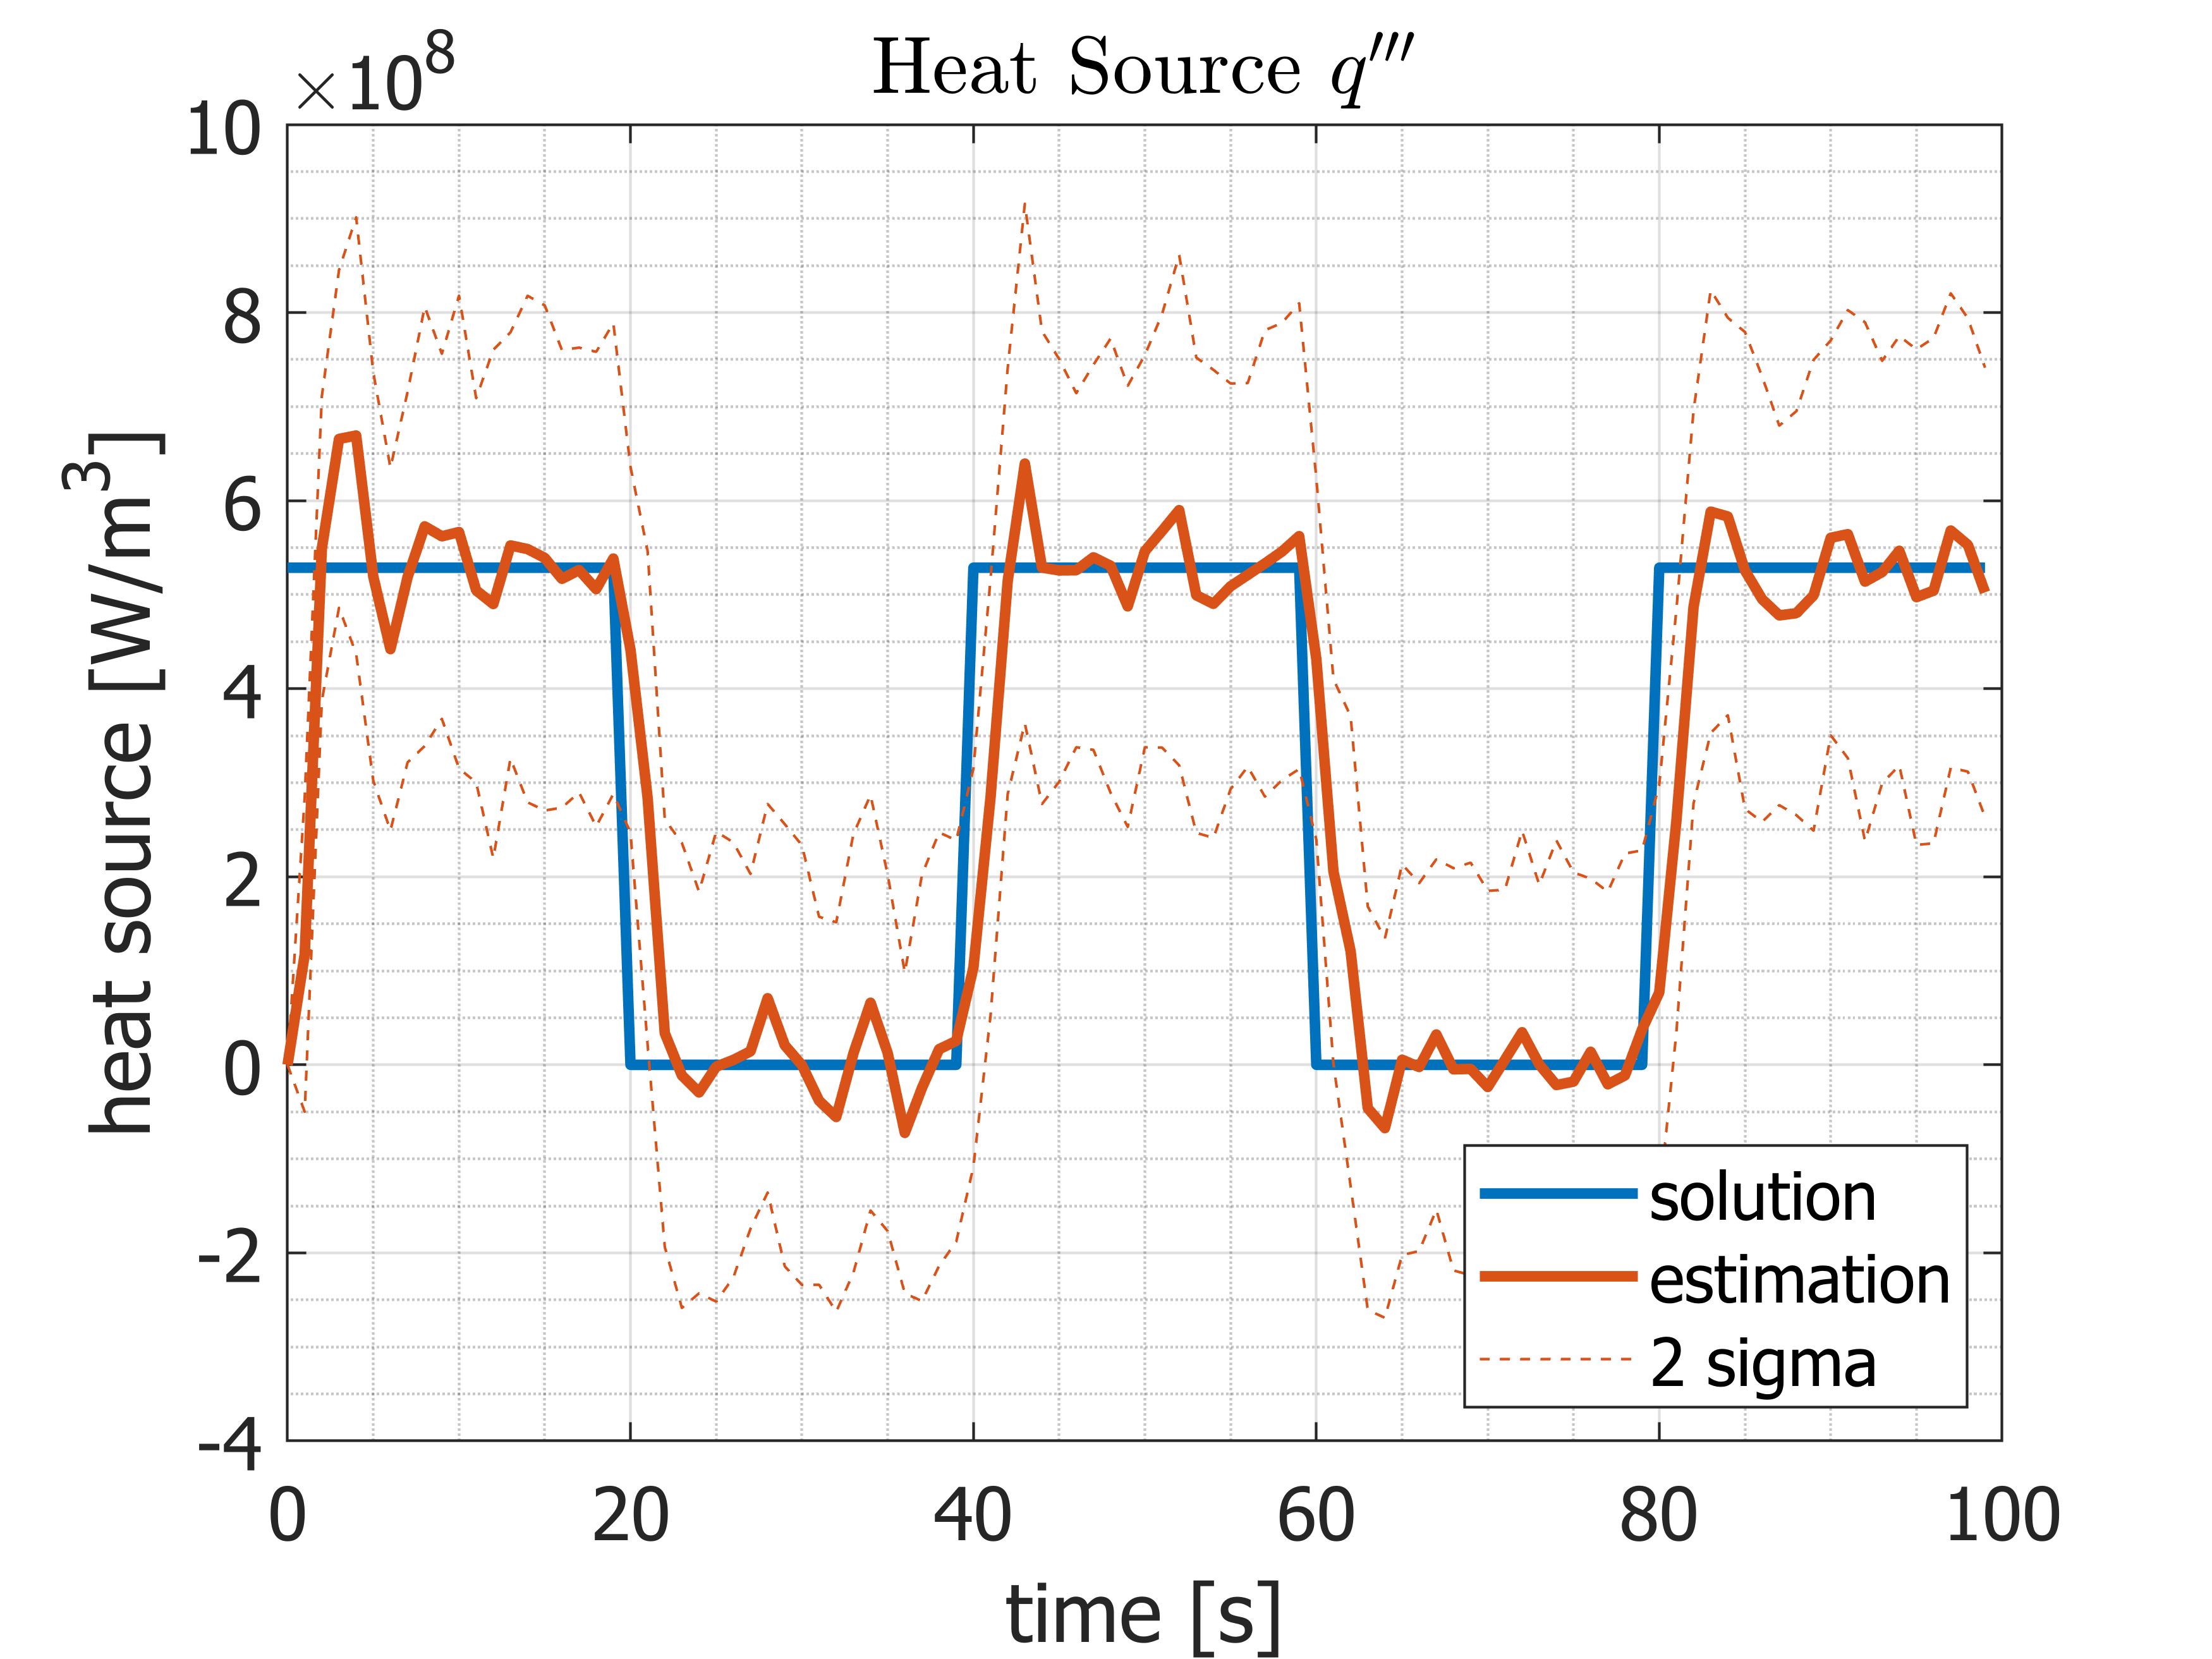

In [22]:
% subplot(2,3,1)
plot(time_grid(id_plot), q_transient_solution(id_plot),'Linewidth',2,'color','#0072BD','displayname','solution')
hold on
plot(time_grid(id_plot), q_transient_est_mean(id_plot),'Linewidth',2,'color','#D95319','displayname','estimation')
hold on
plot(time_grid(id_plot), q_transient_est_mean(id_plot) + 2*q_transient_est_std(id_plot),'--','color','#D95319','displayname','2 sigma')
hold on
plot(time_grid(id_plot), q_transient_est_mean(id_plot) - 2*q_transient_est_std(id_plot),'--','color','#D95319','handlevisibility','off')

title('Heat Source $q^{\prime \prime \prime}$ ', 'Interpreter', 'latex')
xlabel('time [s]')
ylabel('heat source [W/m^3]')
legend('show','location','best')
set(gca,'fontsize',fontsize,'fontname','times')
grid on
grid minor

## heat source reconstruction (discrepancy)


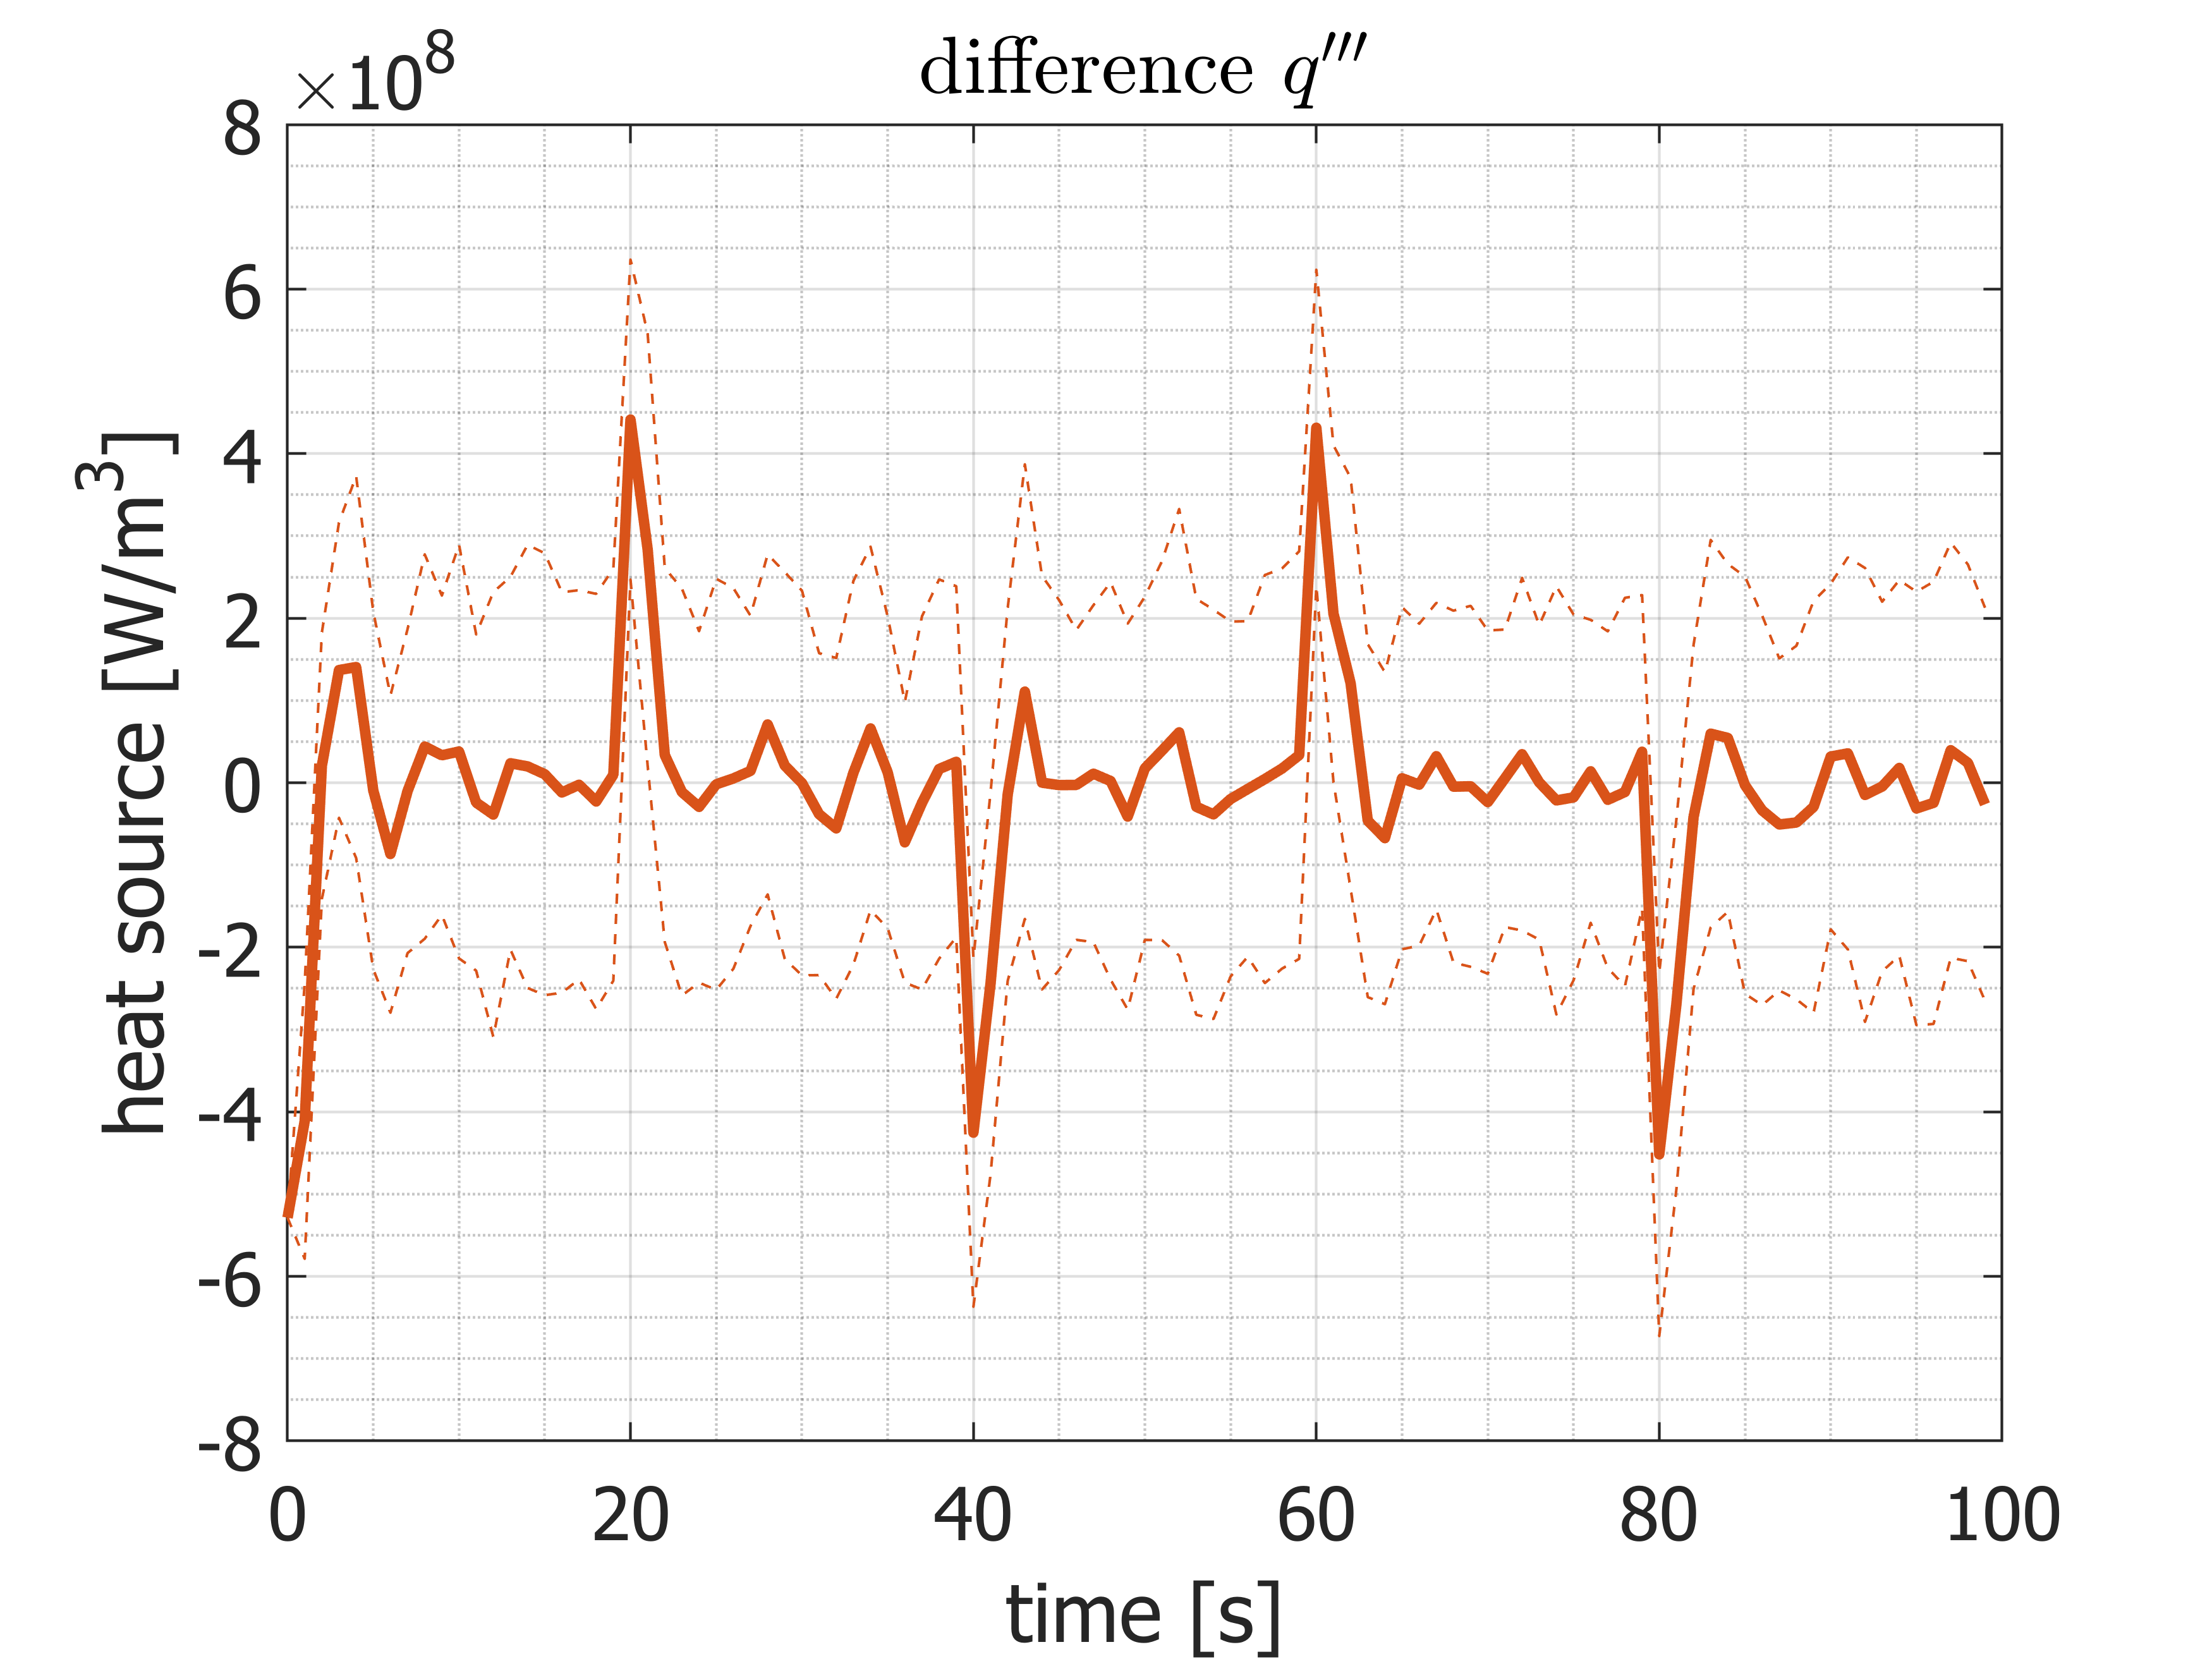

In [23]:
figure;
set(gcf, 'WindowState', 'maximized');
plot(time_grid(id_plot), q_transient_est_mean(id_plot) - q_transient_solution(id_plot),'Linewidth',2,'color','#D95319')
hold on
plot(time_grid(id_plot), q_transient_est_mean(id_plot) - q_transient_solution(id_plot) + 2*q_transient_est_std(id_plot),'--','color','#D95319')
hold on
plot(time_grid(id_plot), q_transient_est_mean(id_plot) - q_transient_solution(id_plot) - 2*q_transient_est_std(id_plot),'--','color','#D95319')

title('difference $q^{\prime \prime \prime}$ ', 'Interpreter', 'latex')
xlabel('time [s]')
ylabel('heat source [W/m^3]')
set(gca,'fontsize',fontsize,'fontname','times')
grid on
grid minor

## peak temperature


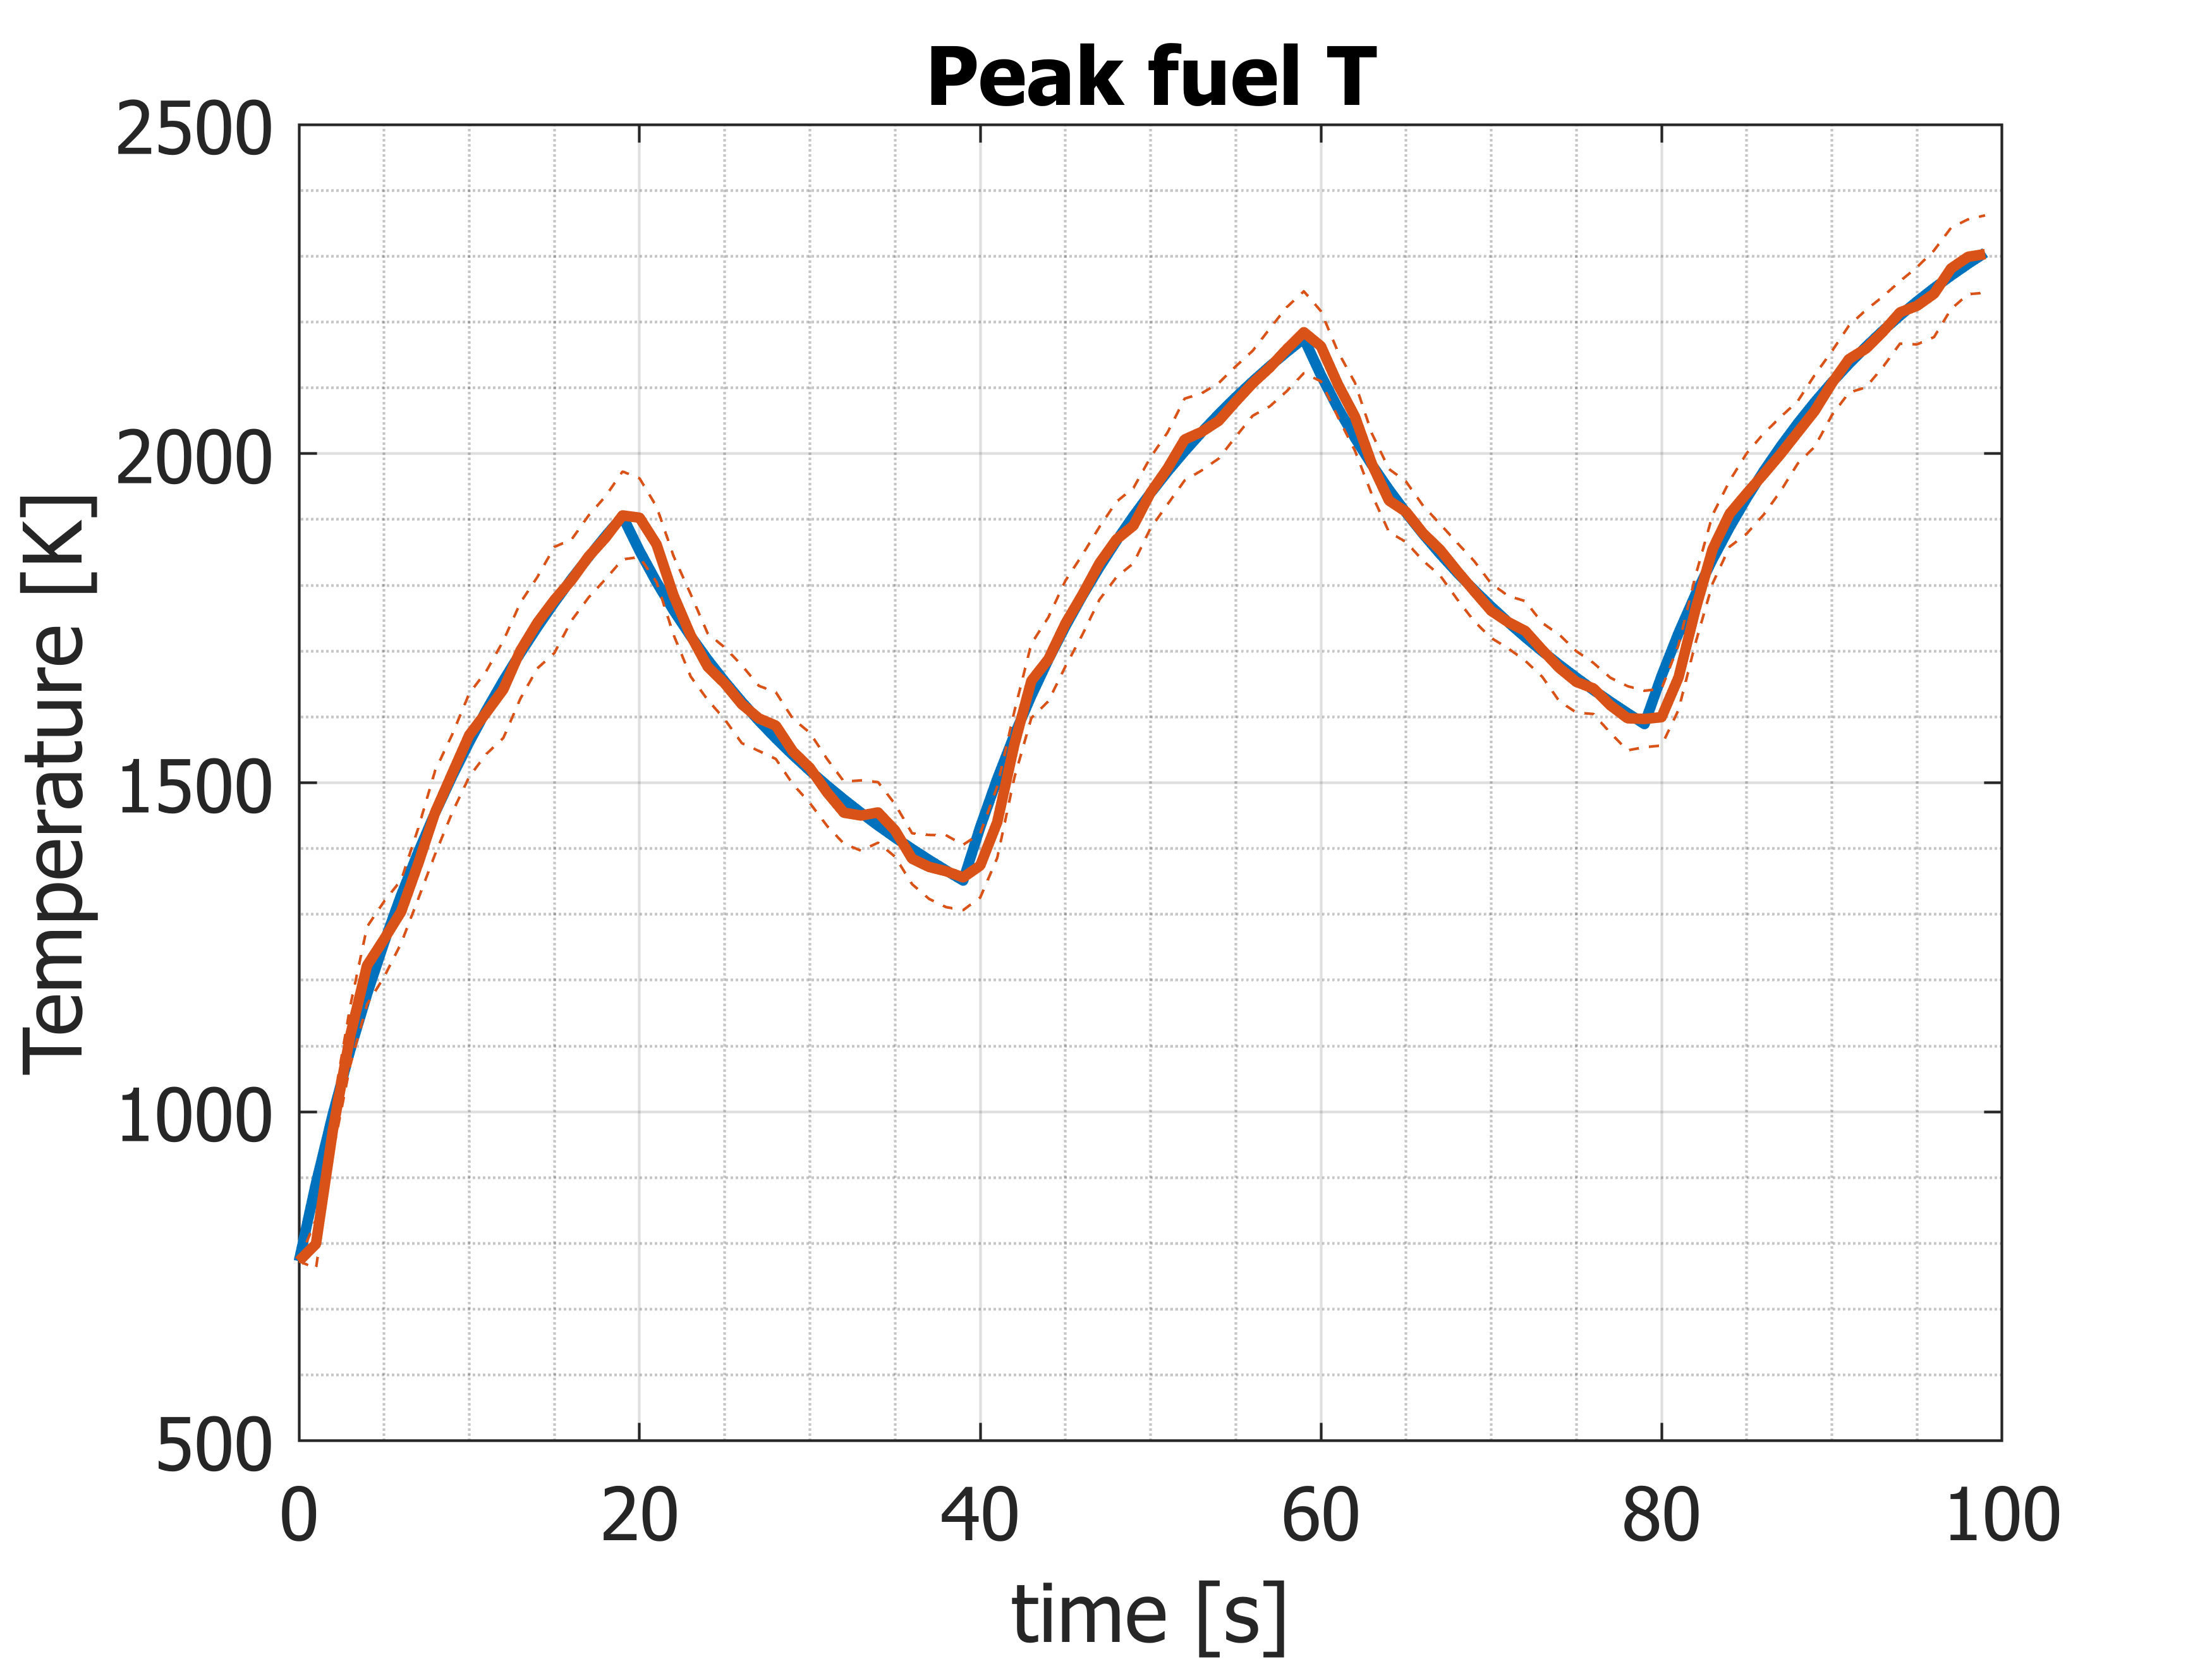

In [24]:
id_peak = 1;
figure;
set(gcf, 'WindowState', 'maximized');
plot(time_grid(id_plot), T_transient_solution(id_peak,id_plot),'Linewidth',2,'color','#0072BD')
hold on
plot(time_grid(id_plot), T_transient_est_mean(id_peak,id_plot),'Linewidth',2,'color','#D95319')
hold on
plot(time_grid(id_plot), T_transient_est_mean(id_peak,id_plot) + 2*T_transient_est_std(id_peak,id_plot),'--','color','#D95319')
hold on
plot(time_grid(id_plot), T_transient_est_mean(id_peak,id_plot) - 2*T_transient_est_std(id_peak,id_plot),'--','color','#D95319')

title('Peak fuel T')
xlabel('time [s]')
ylabel('Temperature [K]')
set(gca,'fontsize',fontsize,'fontname','times')
grid on
grid minor


## peak temperature (discrepancy)


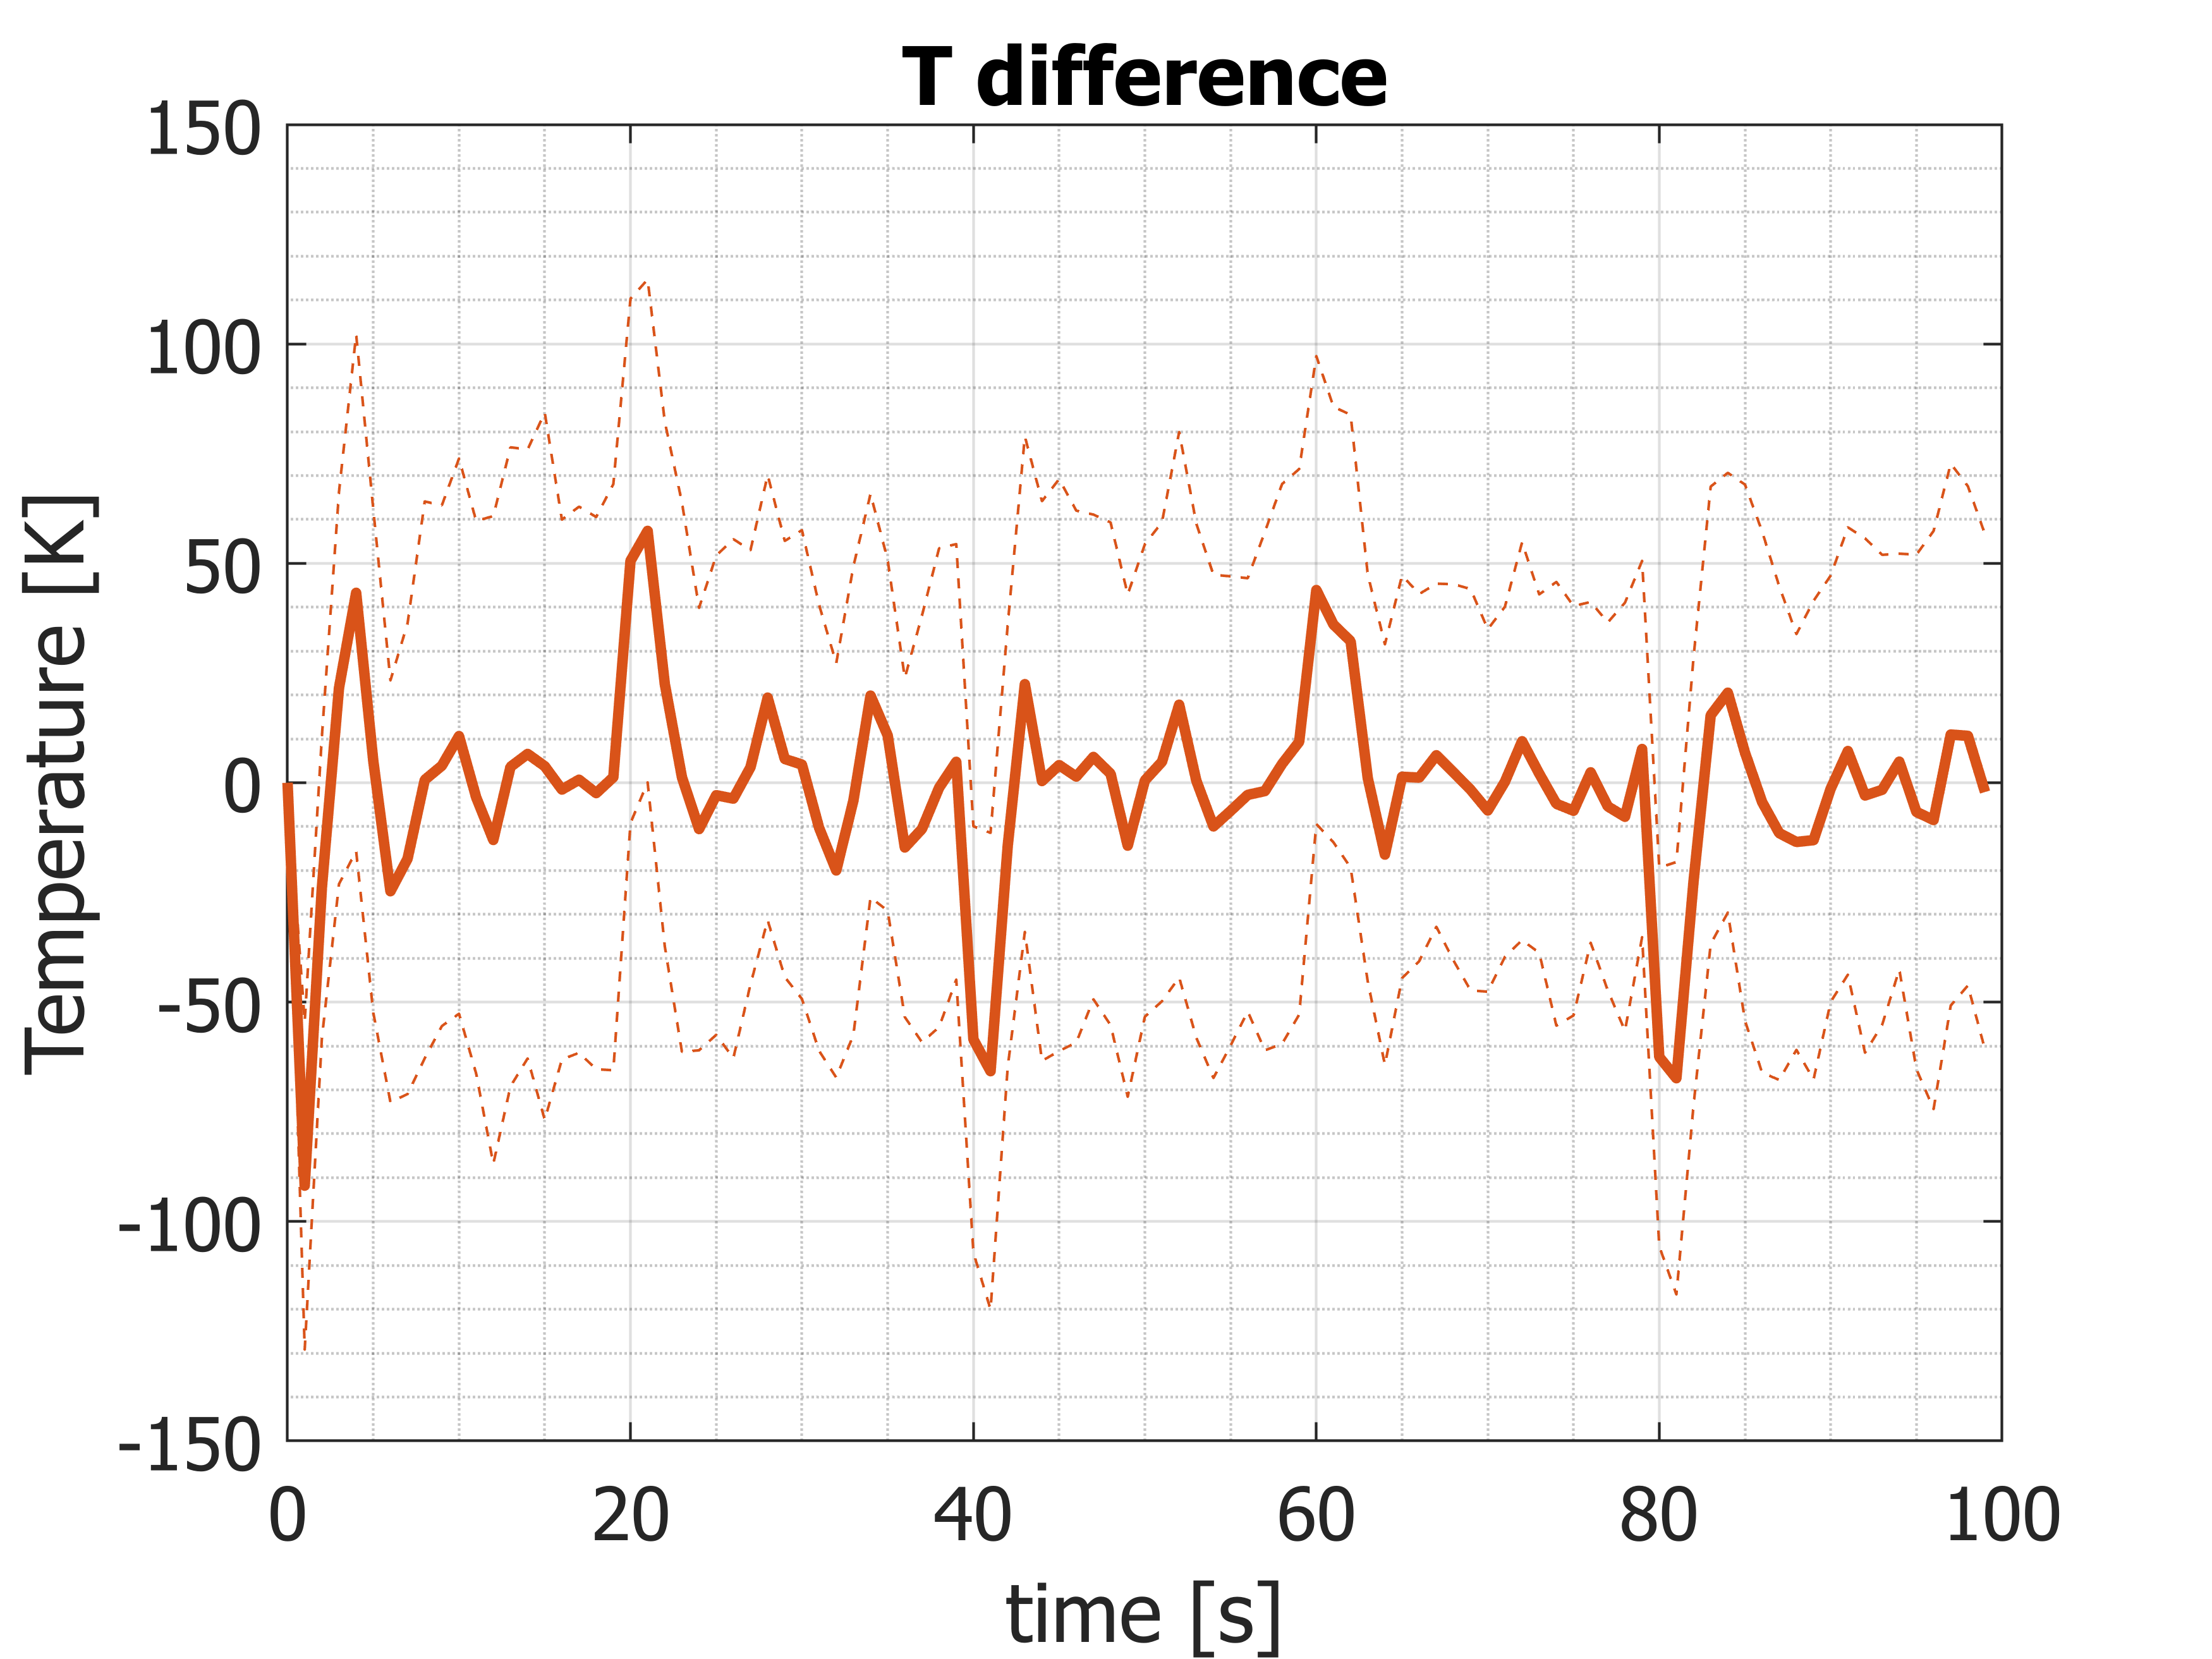

In [25]:
figure;
set(gcf, 'WindowState', 'maximized');
plot(time_grid(id_plot), T_transient_est_mean(id_peak,id_plot) - T_transient_solution(id_peak,id_plot),'Linewidth',2,'color','#D95319')
hold on
plot(time_grid(id_plot), T_transient_est_mean(id_peak,id_plot) - T_transient_solution(id_peak,id_plot) + 2*T_transient_est_std(id_peak,id_plot),'--','color','#D95319')
hold on
plot(time_grid(id_plot), T_transient_est_mean(id_peak,id_plot) - T_transient_solution(id_peak,id_plot) - 2*T_transient_est_std(id_peak,id_plot),'--','color','#D95319')

title('T difference')
xlabel('time [s]')
ylabel('Temperature [K]')
set(gca,'fontsize',fontsize,'fontname','times')
grid on
grid minor

## gap thermal resistance


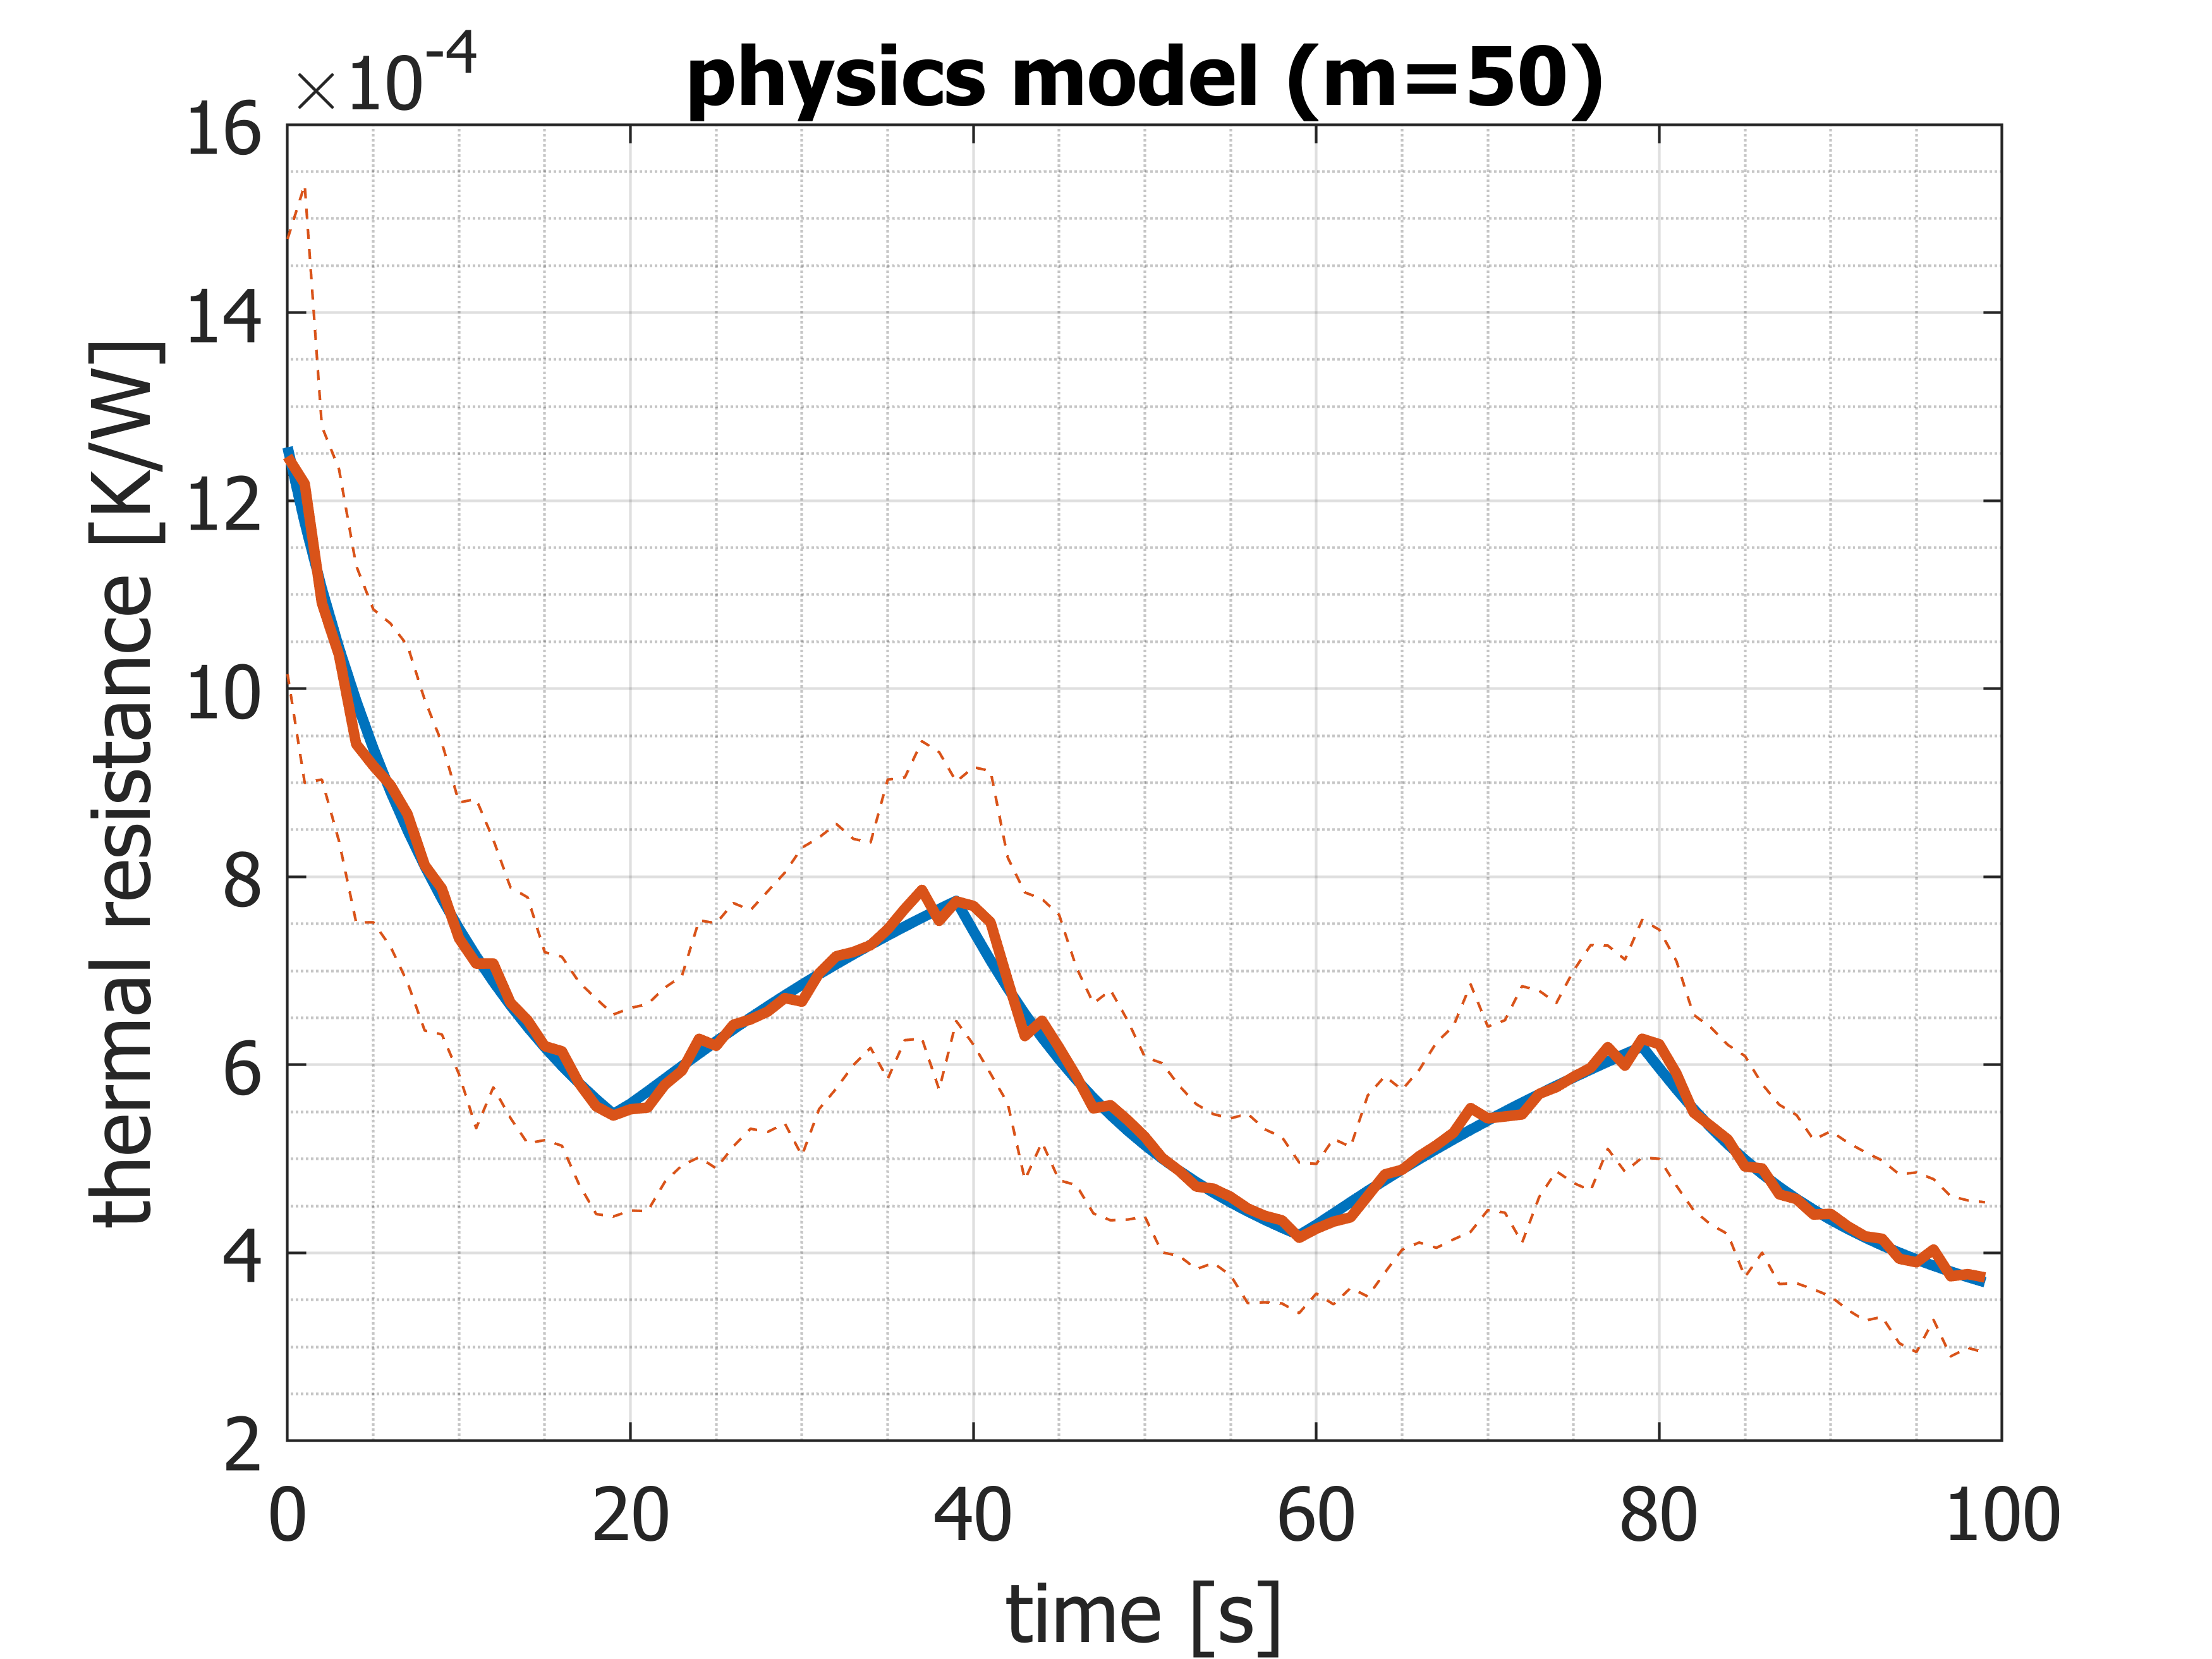

In [26]:
figure;
set(gcf, 'WindowState', 'maximized');
plot(time_grid(id_plot), R_transient_solution(id_plot),'Linewidth',2,'color','#0072BD')
hold on
plot(time_grid(id_plot), R_transient_est_mean(id_plot),'Linewidth',2,'color','#D95319')
hold on
plot(time_grid(id_plot), R_transient_est_mean(id_plot) + 2*R_transient_est_std(id_plot),'--','color','#D95319')
hold on
plot(time_grid(id_plot), R_transient_est_mean(id_plot) - 2*R_transient_est_std(id_plot),'--','color','#D95319')

title("physics model (m=" + num2str(M_sample) + ")")
xlabel('time [s]')
ylabel('thermal resistance [K/W]')
set(gca,'fontsize',fontsize,'fontname','times')
grid on
grid minor

## 1D temperature profile at selected time step


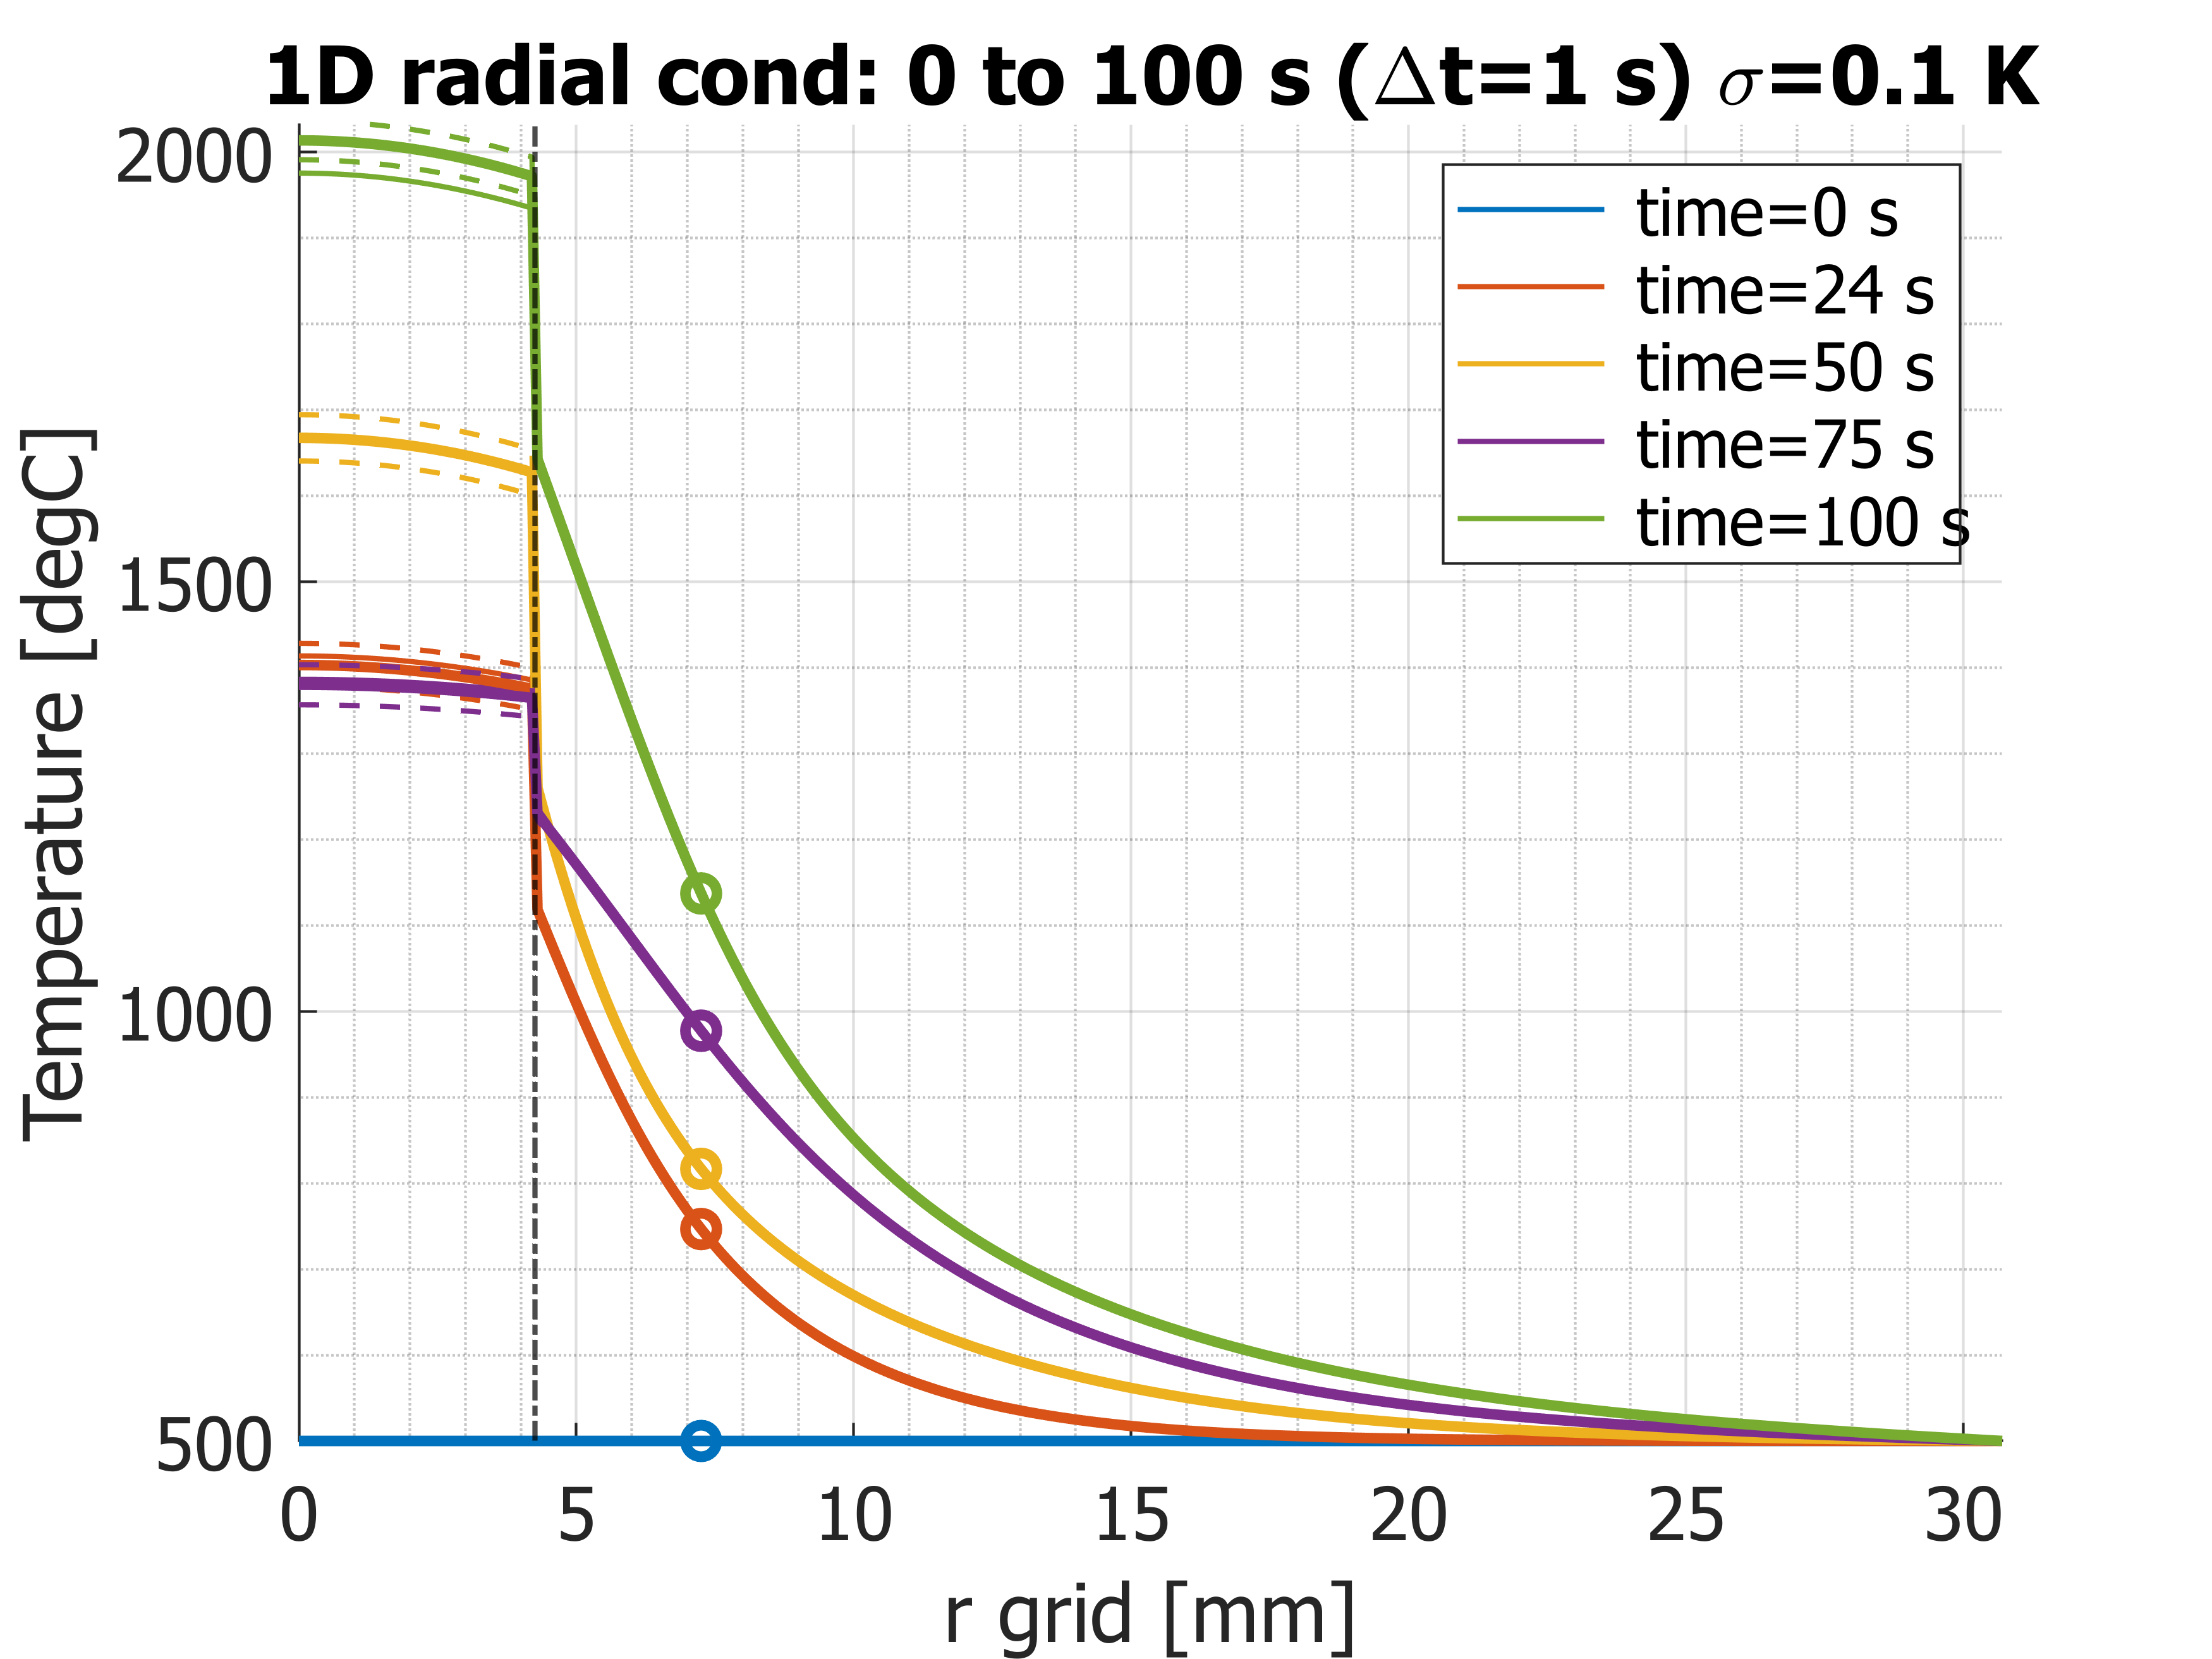

In [27]:
r_step = 1;
idx_transient_plot = [1, round(N_time/4), round(N_time/2), round(N_time*3/4), N_time-r_step+1]; % INPUT to be matched with time grid
myColors = [
    0 0.4470 0.7410; %
    0.8500 0.3250 0.0980; %
    0.9290 0.6940 0.1250; %
    0.4940 0.1840 0.5560; %
    0.4660 0.6740 0.1880; %
    0.3010 0.7450 0.9330; %
];

figure;
set(gcf, 'WindowState', 'maximized'); % temperature history
for m=1:M_sample
for idx=1:length(idx_transient_plot) % sensing
    scatter(1000*r_grid_total(sensor_user_input), T_transient_solution_noisy(sensor_user_input,idx_transient_plot(idx), m) - 273.15,'Linewidth',2,'MarkerEdgeColor', myColors(idx, :),'handlevisibility','off')
    hold on
end
end
for idx=1:length(idx_transient_plot) % original solution
    plot(1000*r_grid_total, T_transient_solution(:,idx_transient_plot(idx)) - 273.15,'Color', myColors(idx, :),'Linewidth',1,'displayname', strcat(' time=', num2str(time_grid(idx_transient_plot(idx))),' s'))
    hold on
end
for idx=1:length(idx_transient_plot) % reconstruction
    plot(1000*r_grid_total, T_transient_est_mean(:,idx_transient_plot(idx)) - 273.15,'Color', myColors(idx, :),'Linewidth',2,'handlevisibility','off')
    hold on
    plot(1000*r_grid_total, T_transient_est_mean(:,idx_transient_plot(idx)) + T_transient_est_std(:,idx_transient_plot(idx))- 273.15,'--','Color', myColors(idx, :),'Linewidth',1,'handlevisibility','off')
    hold on
    plot(1000*r_grid_total, T_transient_est_mean(:,idx_transient_plot(idx)) - T_transient_est_std(:,idx_transient_plot(idx))- 273.15,'--','Color', myColors(idx, :),'Linewidth',1,'handlevisibility','off')
end
hold on
xline(1000*r_grid_total(N_grid_heater),'-.k','Linewidth',1,'handlevisibility','off')

legend('show')
xlabel('r grid [mm]')
ylabel('Temperature [degC]')
title("1D radial cond: 0 to " + num2str(time_end)+ " s (\Deltat=" + num2str(dt)+" s) \sigma="+ num2str(sigma_noise)+ " K")
set(gca,'FontSize',14,'fontname','times')
xlim([0 ro_zro2*1000])
ylim([500 max(T_transient_solution, [], "all") - 273.15])
grid on
grid minor